In [218]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.random import multivariate_normal as mvn

In [219]:
N = 100
dt = 0.1
q1, q2 = 1, 1
s1, s2 = 0.5, 0.5

Q = np.array([[(q1 * dt**3) / 3, 0, (q1 * dt**2) / 2, 0],
              [ 0, (q2 * dt**3) / 3, 0, (q2 * dt**2) / 2],
              [(q1 * dt**2) / 2, 0, q1 * dt, 0],
              [0, (q2 * dt**2) / 2, 0, q2 * dt]])

R = np.array([[s1, 0],
              [0, s2]])

A = np.array([[1, 0, dt, 0],
             [0, 1, 0, dt],
             [0, 0, 1, 0],
             [0, 0, 0, 1]])

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

# Nonlinear state transition function
def f_linear(x):
    return A @ x

def f_nonlinear(x):
    return np.array([0.1 * np.sin(x[0]), 0.1 * np.sin(x[1]), 0, 0])

def f(x):
    return f_linear(x) + f_nonlinear(x)

# Nonlinear observation function
def h_linear(x):
    return H @ x

def h_nonlinear(x):
    return np.array([1.0 * np.sin(x[1]), -1.0 * np.cos(x[0])])

def h(x):
    return h_linear(x) + h_nonlinear(x)

# Jacobians of the state transition and observation functions
def F_jacobian(x):
    return np.array([[1 + 0.1 * np.cos(x[0]), 0, dt, 0],
                    [0, 1 + 0.1 * np.cos(x[1]), 0, dt],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])

def H_jacobian(x):
    return np.array([[1, 1.0 * np.cos(x[1]), 0, 0],
                     [1.0 * np.sin(x[0]), 1, 0, 0]])


In [220]:
v_max = 10.0
x_min, x_max = -10.0, 10.0
y_min, y_max = -10.0, 10.0
damping_factor = 1.5

def f(x):
    x_next = f_linear(x) + f_nonlinear(x)

    # Velocity constraint
    velocity = np.sqrt(x_next[2]**2 + x_next[3]**2)
    if velocity > v_max:
        x_next[2] = (x_next[2] / velocity) * v_max
        x_next[3] = (x_next[3] / velocity) * v_max

    # Damping and direction adjustment as it gets closer to boundaries
    boundary_distance_x = min(x_next[0] - x_min, x_max - x_next[0])
    boundary_distance_y = min(x_next[1] - y_min, y_max - x_next[1])

    # Calculate smooth damping factor using a sigmoid function
    sigmoid = lambda d: 1 / (1 + np.exp(d))

    # Check if the state is within a certain distance of the boundary
    if boundary_distance_x < damping_factor:
        damping_x = sigmoid(boundary_distance_x - damping_factor)

        # Adjust direction of motion
        direction_x = -np.sign(x_next[0] - (x_min + x_max) / 2)
        x_next[2] += direction_x * damping_x * v_max

    if boundary_distance_y < damping_factor:
        damping_y = sigmoid(boundary_distance_y - damping_factor)

        # Adjust direction of motion
        direction_y = -np.sign(x_next[1] - (y_min + y_max) / 2)
        x_next[3] += direction_y * damping_y * v_max

    # Boundary constraint
    x_next[:2] = np.clip(x_next[:2], x_min, x_max)

    return x_next

# Generate data with nonlinear true path and nonlinear observations
x = np.array([0, 0, 1, 1])
states = [x]
measurements = [h(x)[:2]]

for _ in range(N):
    x = f(x) + mvn([0, 0, 0, 0], Q)
    y = h(x) + mvn([0, 0], R)

    states.append(x)
    measurements.append(y)

states = np.array(states)
measurements = np.array(measurements)

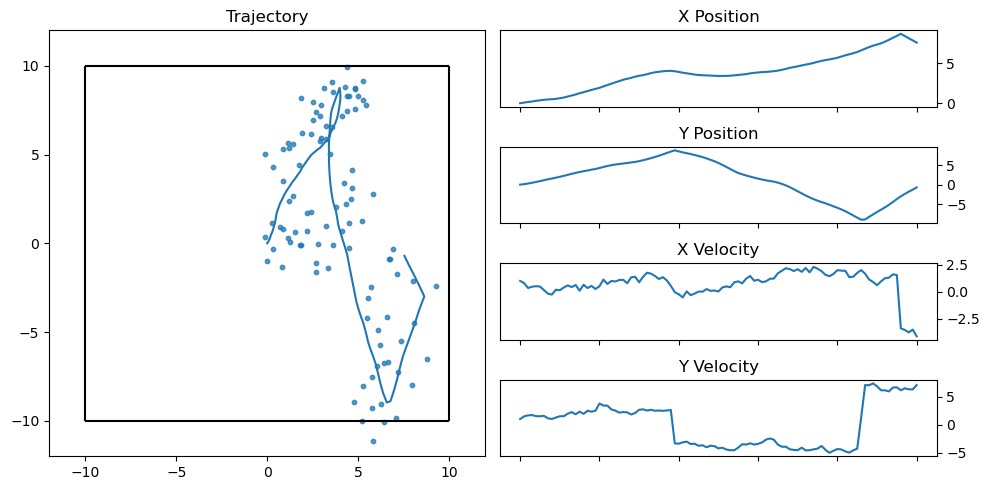

In [221]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 5))

# Create a grid layout with 4 rows and 2 columns
gs = gridspec.GridSpec(4, 2)

# Create a subplot that spans all 4 rows in the first column
ax1 = plt.subplot(gs[:, 0])
ax1.plot(states[:, 0], states[:, 1], label='True trajectory')
ax1.scatter(measurements[:, 0], measurements[:, 1], s = 10, alpha = 0.75, label='Noisy observations')
ax1.hlines(y_min, x_min, x_max, color='black')
ax1.hlines(y_max, x_min, x_max, color='black')
ax1.vlines(x_min, y_min, y_max, color='black')
ax1.vlines(x_max, y_min, y_max, color='black')
ax1.set_xlim(x_min-2, x_max+2)
ax1.set_ylim(y_min-2, y_max+2)
#ax1.legend()

ax1.set_title('Trajectory')

titles = ['X Position', 'Y Position', 'X Velocity', 'Y Velocity']

# Create four subplots, one in each row of the second column
ax2 = None
for i in range(4):
    ax2 = plt.subplot(gs[i, 1])
    
    ax2.plot(states[:, i], label='True trajectory')    
    ax2.set_title('{}'.format(titles[i]))
    ax2.yaxis.tick_right()
    plt.setp(ax2.get_xticklabels(), visible=False)

plt.tight_layout()
plt.show()